In [22]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure

#!pip install ipython-autotime

In [2]:
#Upload Data and Define Parameters

file_type = '.fastq'

aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly_S3_L001_R1_001.fastq').readlines()
rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly-NaOH_S4_L001_R1_001.fastq').readlines()

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9


#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAA'
#Position motif2 starts at
motif2_start = 23
#Motif2 define
motif2 = 'AAAAGATCGGAAGAGCACACGTCT'



In [65]:
def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
    
    if file_type == '.fasta':
        high_quality = list_of_seqs[1::2]
        print('Total seqs: '+str(len(high_quality)))
    
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                if (motif2_start - motif_start - len(motif)) == len(seq[(motif_start-1)+len(motif):(motif2_start-1)]):
                    trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)])
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def rscape_format(num_seqs_to_analyze, top_seqs):
    #Create file for R-Scape Covariation
    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/gly_rscape"+str(num_seqs_to_analyze)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs[:num_seqs_to_analyze]:
      counter+=1
      f.write(str(counter)+'\t'+seq[0]+'\n')
    f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')
    
def make_heatmap_bp(position_lhs, aa_not_rna_top_seqs):
    print(str(position_lhs+1)+'/'+ str(len(aa_not_rna_top_seqs[0])-position_lhs))
    bps = []
    for seq in range(len(aa_not_rna_top_seqs)):
        bps.append([aa_not_rna_top_seqs[seq][0][position_lhs], aa_not_rna_top_seqs[seq][0][len(aa_not_rna_top_seqs[seq][0])-position_lhs-1]])
    bp_options = [['A', 'A'],['A', 'C'],['A', 'G'],['A', 'T'],['C', 'A'],['C', 'C'],['C', 'G'],['C', 'T'],['G', 'A'],['G', 'C'],['G', 'G'],['G', 'T'],['T', 'A'],['T', 'C'],['T', 'G'],['T', 'T']]
    option_counts = []
    for option in bp_options:
        option_counts.append(bps.count(option))
    
    xticks = ['A','C','G','T']
    yticks = ['A','C','G','T']
    sns.heatmap(np.array(option_counts).reshape(4,4), cmap='coolwarm', xticklabels=xticks, yticklabels=yticks)
    print(option_counts)
    plt.title('BP '+str(position_lhs+1))
    plt.show()
    
    
    

In [4]:
#AA CONTROL
#STATISTICS (note: this takes a few mins per round)
aa_ctrl_processed_seqs, aa_ctrl_processed_seqs_unique = preprocess_seqs(aa_sequences)
aa_ctrl_top_seqs = Counter(aa_ctrl_processed_seqs).most_common(100)
print(aa_ctrl_top_seqs[:10])

Total seqs: 2818273
High quality seqs: 2725931
Seqs after trimming: 2313803
[('AGATCGGAAGAGCACACGT', 6358), ('GCCGGCAAAAGATCGGAAG', 729), ('CAAAAGATCGGAAGAGCAC', 284), ('GCCGGGGGGGCAAAAGATC', 267), ('GCCGGGGGGGGCAAAAGAT', 262), ('GCCGGGCAAAAGATCGGAA', 256), ('GCCGGGGGGCAAAAGATCG', 249), ('AAAAGATCGGAAGAGCACA', 236), ('GCCGGGGCAAAAGATCGGA', 181), ('GCCGGGGCGGCAAAAGATC', 170)]


In [5]:
#RNA CONTROL
#STATISTICS (note: this takes a few mins per round)
rna_ctrl_processed_seqs, rna_ctrl_processed_seqs_unique = preprocess_seqs(rna_only_sequences)
rna_ctrl_top_seqs = Counter(rna_ctrl_processed_seqs).most_common(100)
print(rna_ctrl_top_seqs[:10])



Total seqs: 681129
High quality seqs: 651333
Seqs after trimming: 480551
[('AGATCGGAAGAGCACACGT', 4113), ('GCCGGCAAAAGATCGGAAG', 843), ('GCCAAAAGATCGGAAGAGC', 257), ('ACCGGCAAAAGATCGGAAG', 145), ('GCCTGGCAAAAGATCGGAA', 140), ('GCCGGGCAAAAGATCGGAA', 135), ('GCCCGGCAAAAGATCGGAA', 135), ('GCCGGGTGGCAAAAGATCG', 128), ('GCCGGGGGTGGCAAAAGAT', 112), ('GCAAAAGATCGGAAGAGCA', 108)]


In [6]:
#AA NOT RNA 
#STATISTICS (note: this takes a few mins per round)

aa_rna_no_overlap = list(filterfalse(set(rna_ctrl_processed_seqs).__contains__, aa_ctrl_processed_seqs))

print('Seqs in AA but not RNA: '+str(round(len(aa_rna_no_overlap))))

aa_not_rna_top_seqs = Counter(aa_rna_no_overlap).most_common(10000)
print(aa_not_rna_top_seqs[:10])

#Save file for R-Scape
rscape_format(1002, aa_not_rna_top_seqs)
print('R-Scape file saved')

Seqs in AA but not RNA: 2164921
[('GCCTGATTGTAGATTGGGC', 88), ('GCCAGTTTGTAGAATTGGC', 61), ('GCCGTCTTGTAGAGAGGGC', 61), ('GCCTGTTTGTAGAATGGGC', 60), ('GCCGGAGCGTAAGTGAGGC', 59), ('GCCGGTCGTGGCGATTGGC', 56), ('GCCGAGTTGTAGATGAGGC', 52), ('GCCGGAGGGGAACTCTGGC', 48), ('GCCAGTTTGAGGGATTGGC', 47), ('GCCGGATTGAGGGTTCGGC', 46)]
R-Scape file saved


1/2
[0, 0, 0, 0, 0, 0, 0, 0, 64, 9928, 5, 3, 0, 0, 0, 0]


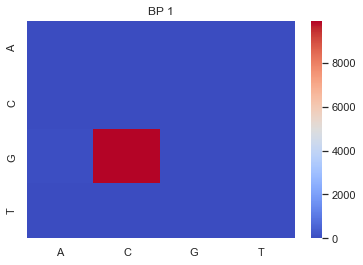

2/1
[0, 0, 0, 0, 10, 55, 9932, 2, 1, 0, 0, 0, 0, 0, 0, 0]


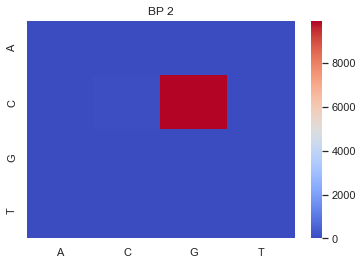

3/0
[1, 0, 0, 0, 11, 1, 9985, 1, 0, 0, 1, 0, 0, 0, 0, 0]


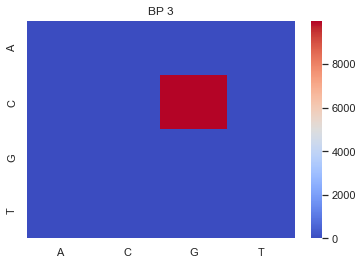

4/-1
[7, 8, 59, 1075, 1, 7, 311, 1, 484, 1441, 1202, 2786, 1032, 6, 1563, 17]


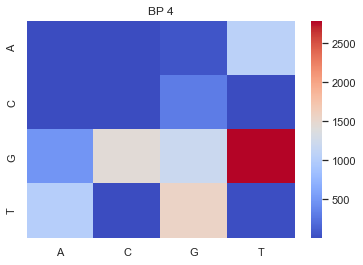

5/-2
[23, 5, 170, 1022, 3, 2, 572, 2, 443, 1474, 431, 2058, 2464, 24, 1279, 28]


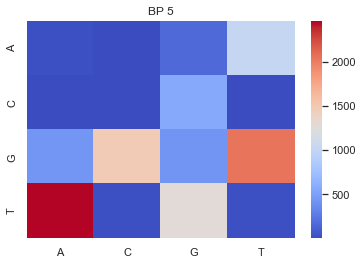

6/-3
[42, 48, 471, 2007, 11, 25, 1159, 12, 288, 740, 330, 838, 2284, 84, 1560, 101]


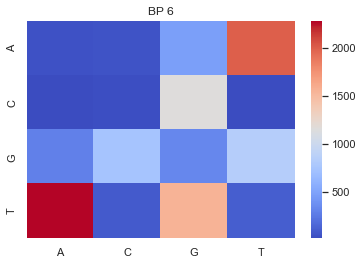

7/-4
[98, 2, 357, 971, 82, 2, 1522, 19, 625, 382, 1006, 667, 2124, 9, 2048, 86]


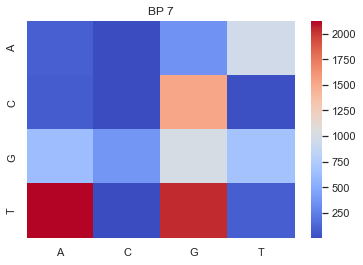

8/-5
[102, 22, 692, 256, 124, 2, 1123, 18, 293, 1217, 2177, 437, 526, 78, 2649, 284]


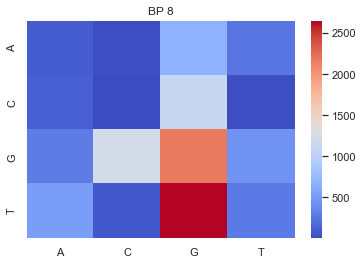

In [66]:
#Show Covariation
for i in range(8):
    make_heatmap_bp(i, aa_not_rna_top_seqs)

<Figure size 432x288 with 0 Axes>

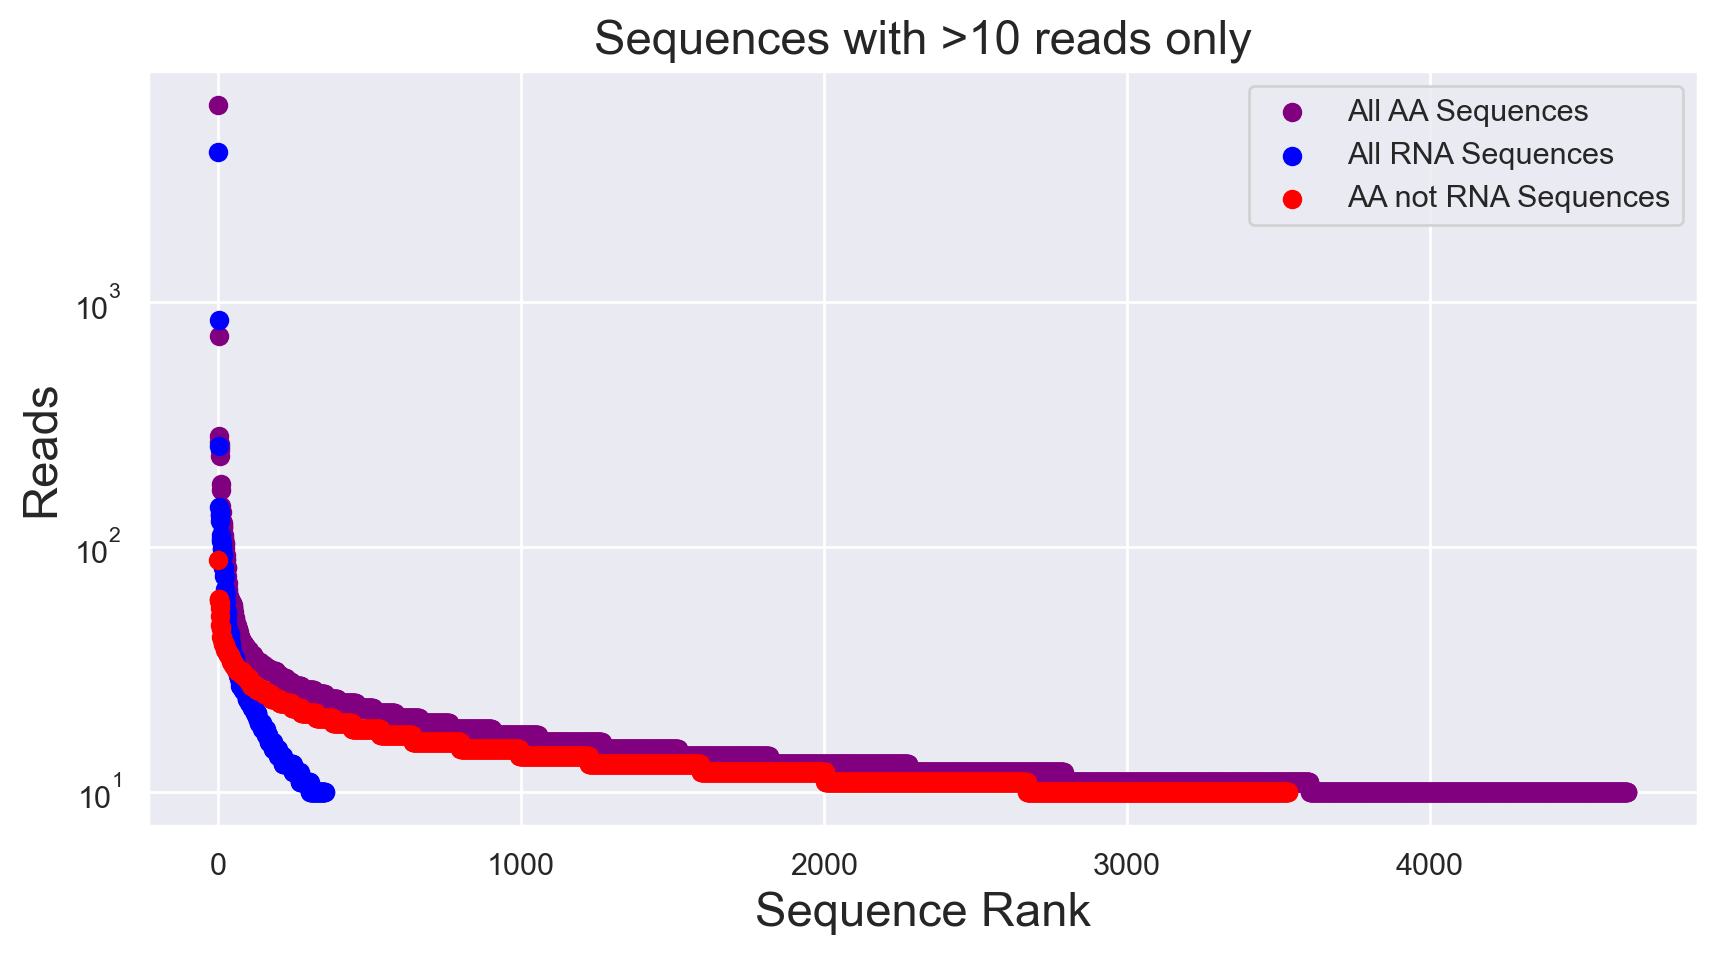

In [64]:
#Sutherland distribution plot all seqs with >10 reads
plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_aa = sorted(dict(Counter(aa_ctrl_processed_seqs)).values(), reverse=True)
ordered_counts_rna = sorted(dict(Counter(rna_ctrl_processed_seqs)).values(), reverse=True)
ordered_counts_aa_not_rna = sorted(dict(Counter(aa_rna_no_overlap)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_aa if i >= 10])+1), [i for i in ordered_counts_aa if i >= 10], color = 'purple', label = 'All AA Sequences')
plt.scatter(range(1,len([i for i in ordered_counts_rna if i >= 10])+1), [i for i in ordered_counts_rna if i >= 10], color = 'blue', label = 'All RNA Sequences')
plt.scatter(range(1,len([i for i in ordered_counts_aa_not_rna if i >= 10])+1), [i for i in ordered_counts_aa_not_rna if i >= 10], color = 'red', label = 'AA not RNA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.title('Sequences with >10 reads only', fontsize = 17)
plt.yscale('log')
plt.legend()
